In [1]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')

import cv2
from commonfunctions import *
from stemRemoval import stemRemoval, rle
from skimage.util import img_as_ubyte
from skimage.measure import label, regionprops
from skimage.draw import rectangle_perimeter

In [2]:
# custom split_objects (same as original but returns the stafflineSpacing)
def test_split_objects(img_thresh):
    img_objects , staffLines, staffLineSpacing, staffLineThickness = staffLineRemoval(img_thresh, 1)
    print('staffLines : ' + str(staffLines))
    show_images([img_objects])
    height = img_objects.shape[0]
    count_blocks = len(staffLines) // 5
    
    if count_blocks > 1: 
        padding_up = (staffLines[5] - staffLines[4]) // 2 
        padding_down = padding_up 
    else:
        padding_up = staffLines[0]
        padding_down =  height - staffLines[4]

    blocks = []
    blocks_orginal = []
    blocks_tops = []
    for i in range(0 , count_blocks):
        if i == 0:
            blocks.append(img_objects[0: staffLines[i * 5 + 4] + padding_down,:])
            blocks_orginal.append(img_thresh[0: staffLines[i * 5 + 4] + padding_down,:])
            blocks_tops.append(0)
        elif i == count_blocks - 1:
            blocks.append(img_objects[staffLines[i * 5] - padding_up: height ,:])            
            blocks_orginal.append(img_thresh[staffLines[i * 5] - padding_up: height ,:])            
            blocks_tops.append(staffLines[i * 5] - padding_up)
        else:
            blocks.append(img_objects[staffLines[i * 5] - padding_up: staffLines[i * 5 + 4] + padding_down,:])
            blocks_orginal.append(img_thresh[staffLines[i * 5] - padding_up: staffLines[i * 5 + 4] + padding_down,:])
            blocks_tops.append(staffLines[i * 5] - padding_up)
    print('block_tops : ' + str(blocks_tops))
    staffHeight = staffLines[4] - staffLines[3]
    
    objects = []
    # TODO: temporary solution add an array to store for each block the starting staffline
    block_info = []
    for i  in  range(count_blocks):
        contours, hier = cv2.findContours(255 - blocks[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnt = []
        for j in range (0, len(contours)):
            if hier[0,j,3] == -1:
                cnt.append(contours[j])
        cnt, boxes_sorted = sort_contours_horizontally(cnt)        
        for c in cnt:
            Xmin = int(np.min(c[:,0, 0]))
            Xmax = int(np.max(c[:,0, 0]))
            Ymin = int(np.min(c[:,0, 1]))
            Ymax = int(np.max(c[:,0, 1]))

            object_width = Xmax - Xmin
            object_height = Ymax - Ymin
            if object_width > staffHeight//2: 
                current_obj = blocks[i][Ymin:Ymax, Xmin:Xmax]
                objects.append(current_obj)
                # show_images([current_obj])
                block_info.append((i*5, blocks_tops[i] + Ymin))
                # print('Ymin : ' + str(Ymin))
                # print('block_tops[' + str(i) + '] : ' +  str(blocks_tops[i]))
                # print('block_Ymin : ' + str(blocks_tops[i] + Ymin))                  
            elif object_height <= staffHeight//2:
                point_img = np.ones((blocks[i].shape[0],15))
                point_img[blocks[i].shape[0]//2-3:blocks[i].shape[0]//2+3, 5:10] = 0
                objects.append(point_img)
                block_info.append((i*5, blocks_tops[i] + Ymin))
                # print('Ymin : ' + str(Ymin))
                # print('block_tops[' + str(i) + '] : ' +  str(blocks_tops[i]))
                # print('block_Ymin : ' + str(blocks_tops[i] + Ymin))
    return (objects, staffLines, block_info, staffHeight, staffLineThickness)

staffLines : [ 34  53  71  90 109 211 230 249 268 287 377 396 415 434 453]


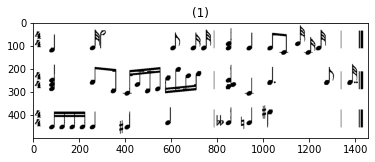

block_tops : [0, 160, 326]


In [3]:
img = rgb2gray(io.imread('../dataset/scanned/13.PNG'))
noisy_img = img_as_ubyte(img)
img_median_filtered = hybridMedian(noisy_img)
img_median_filtered = img_median_filtered.astype(np.uint8)
# img_median_filtered = median(noisy_img)
# gaussian filtering
img_gaussian_filtered = gaussian(img_median_filtered, sigma=0.2)
img_gaussian_filtered = (img_gaussian_filtered * 255).astype(np.uint8)

# image rotation
image_rotated = skew_angle_hough_transform(img_gaussian_filtered)
image_rotated = (image_rotated * 255).astype(np.uint8)

# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)

objects, staffLines, block_info, staffLineSpacing, staffLineThickness = test_split_objects(binary)
# print(staffLineSpacing)


[(0, 13), (0, 76), (0, 39), (0, 53), (0, 31), (0, 35), (0, 44), (0, 44), (0, 32), (0, 26), (0, 45), (0, 46), (0, 13), (0, 0), (0, 64), (0, 32), (0, 36), (5, 163), (5, 254), (5, 216), (5, 185), (5, 241), (5, 194), (5, 257), (5, 194), (5, 181), (5, 257), (5, 257), (5, 213), (10, 502), (10, 357), (10, 420), (10, 382), (10, 388), (10, 388), (10, 426), (10, 388), (10, 369), (10, 403), (10, 370), (10, 410), (10, 370), (10, 361), (10, 379)]
staffLines : [ 37  56  74  93 112 214 233 252 271 290 380 399 418 437 456]


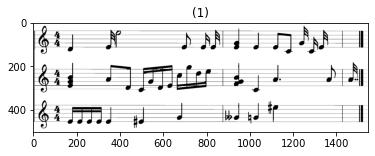

block_tops : [0, 163, 329]


In [127]:
# for bi in block_info:
#     x, y = bi
#     print('x : ' + str(x)),
#     print(', y : ' + str(y))
print(block_info)
objects, staffLines, block_info, staffLineSpacing, staffLineThickness = test_split_objects(binary)

In [4]:

def classify_note(note_centroid, block_info, staffLines, staffLineSpacing):
    # unpack the block info
    top_staff_y_ind, block_Ymin = block_info
    print('block_Ymin : ' + str(block_Ymin))
    # get the staffLines involved with the current block
    block_staff_lines = staffLines[top_staff_y_ind:top_staff_y_ind + 5]
    top_staff_y = block_staff_lines[0]
    # Add the to the centroid the Ymin of the clipped object to ensure it has its base from the beginning of the image
    note_centroid = note_centroid + block_Ymin
    num_spaces = abs(note_centroid - top_staff_y) // staffLineSpacing
    print('num_spaces : ' + str(num_spaces))
    thresh_near_line = staffLineSpacing / 10 # number of pixels difference to say the centroid is near the line
    print('block lines : ' + str(block_staff_lines))
    print('note_centroid : ' + str(note_centroid))
    # TODO : Add support for ledges
    if note_centroid < block_staff_lines[0]:
        if num_spaces == 0:
            if block_staff_lines[0] - note_centroid <= thresh_near_line:
                print('f2')
                note_pitch = 'f2'
            elif note_centroid - (block_staff_lines[0] - staffLineSpacing) <= thresh_near_line:
                print('a2')
                note_pitch = 'a2'
            else:
                print('g2')
                note_pitch = 'g2'
        elif num_spaces == 1:
            if (block_staff_lines[0] - staffLineSpacing) - note_centroid <= thresh_near_line:
                print('a2')
                note_pitch = 'a2'
            elif note_centroid - (block_staff_lines[0] - 2 * staffLineSpacing) <= thresh_near_line:
                print('c3')
                note_pitch = 'c3'
            else:
                print('b2')
                note_pitch = 'b2'
    elif num_spaces == 0:
        if note_centroid - block_staff_lines[0] <= thresh_near_line:
            print('f2')
            note_pitch = 'f2'
        elif block_staff_lines[1] - note_centroid <= thresh_near_line:
            print('d2')
            note_pitch = 'd2'
        else:
            print('e2')
            note_pitch = 'e2'
    elif num_spaces == 1:
        if note_centroid - block_staff_lines[1] <= thresh_near_line:
            print('d2')
            note_pitch = 'd2'
        elif block_staff_lines[2] - note_centroid <= thresh_near_line:
            print('b1')
            note_pitch = 'b1'
        else:
            print('c2')
            note_pitch = 'c2'
    elif num_spaces == 2:
        if note_centroid - block_staff_lines[2] <= thresh_near_line:
            print('b1')
            note_pitch = 'b1'
        elif block_staff_lines[3] - note_centroid <= thresh_near_line:
            print('g1')
            note_pitch = 'g1'
        else:
            print('a1')
            note_pitch = 'a1'
    elif num_spaces == 3:
        if note_centroid - block_staff_lines[3] <= thresh_near_line:
            print('g1')
            note_pitch = 'g1'
        elif (block_staff_lines[4]) - note_centroid <= thresh_near_line:
            print('e1')
            note_pitch = 'e1'
        else:
            print('f1')
            note_pitch = 'f1'
    elif num_spaces == 4:
        if note_centroid - block_staff_lines[4] <= thresh_near_line:
            print('e1')
            note_pitch = 'e1'
        elif ((block_staff_lines[4] + staffLineSpacing) - note_centroid) <=thresh_near_line:
            print('c1')
            note_pitch = 'c1'
        else:
            print('d1')
            note_pitch = 'd1'
    else:
        if (note_centroid - (block_staff_lines[4] + staffLineSpacing)) <= thresh_near_line:
            print('c1')
            note_pitch = 'c1'
        elif abs((block_staff_lines[4] + 2 * staffLineSpacing) - note_centroid) <= thresh_near_line:
            print('a0')
            note_pitch = 'a0'
        else:
            print('b0')
            note_pitch = 'b0'
    return note_pitch

    

In [9]:
def calc_duration(cent_y, cent_x, object, note_pos, staffLineSpacing):
    print('centy', cent_y)
    print('centx', cent_x)
    print('object', object)
    print('note_pos', note_pos)
    print('staffLineSpacing', staffLineSpacing)
    if note_pos == 'bottom':
        min_y = int(cent_y - staffLineSpacing) # to get to the point above the note head
        if int(cent_x + staffLineSpacing) >= object.shape[1]:
            detection_line_col = int(cent_x - staffLineSpacing)
        else:
            detection_line_col = int(cent_x + staffLineSpacing)
        detection_line = np.array(object[0:min_y, detection_line_col], ndmin=1)
        
    elif note_pos == 'top':
        max_y = int(cent_y + staffLineSpacing) # to get to the point below the note head
        if int(cent_x - staffLineSpacing) <= 0:
            detection_line_col =  int(cent_x + staffLineSpacing)
        else:
            detection_line_col = int(cent_x - staffLineSpacing)
        detection_line = np.array(object[max_y:object.shape[0], detection_line_col])

    mask = np.where(detection_line > 0, 1, 0)
    print('mask', mask)
    runlengths, startpositions, values = rle(mask)
    num_startpositions = len(startpositions[np.nonzero(values)[0]])
    print('num_startpositions : ' + str(num_startpositions))
    if num_startpositions == 1:
        note_duration = 8
    elif num_startpositions == 2:
        note_duration = 16
    elif num_startpositions == 3:
        note_duration = 32
    
    return note_duration

stems (positions, widths) found:  [(20, 3), (80, 4)]


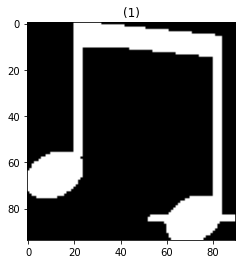

rectL_sum 34935
rectR_sum 66810
The number of labels : 3
block_Ymin : 43
num_spaces : 3.0
block lines : [ 34  53  71  90 109]
note_centroid : 108.87622149837134
e1
The beam is above the notes
centy 65.87622149837134
centx 11.742671009771987
object [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
note_pos bottom
staffLineSpacing 19
mask [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
num_startpositions : 1
block_Ymin : 43
num_spaces : 4.0
block lines : [ 34  53  71  90 109]
note_centroid : 127.8957654723127
c1
The beam is above the notes
centy 84.8957654723127
centx 72.10097719869707
object [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
note_pos bottom
staffLineSpacing 19
mask [0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

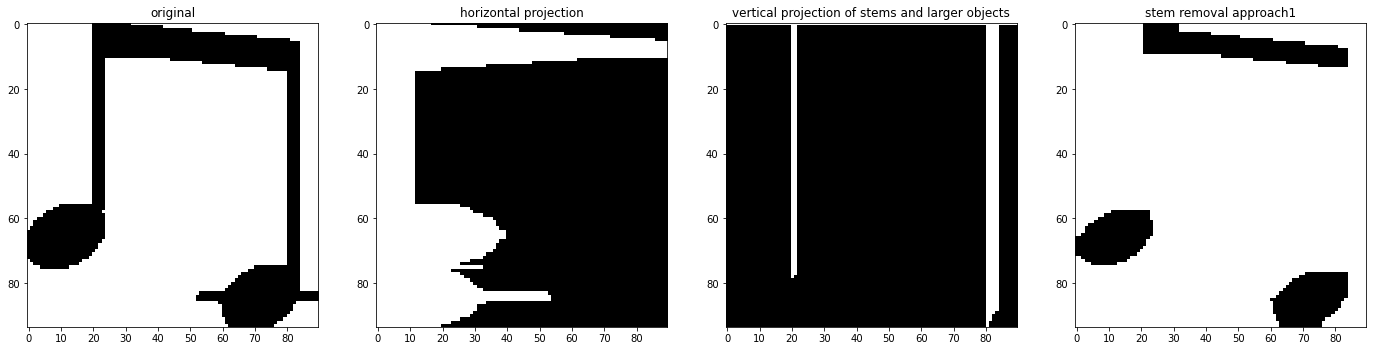

stems (positions, widths) found:  [(21, 3), (111, 3)]


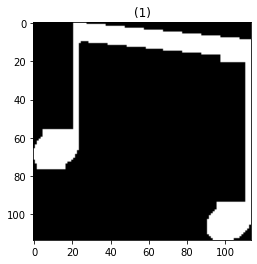

rectL_sum 37740
rectR_sum 122145
The number of labels : 3
block_Ymin : 191
num_spaces : 2.0
block lines : [211 230 249 268 287]
note_centroid : 257.2083333333333
a1
The beam is above the notes
centy 66.20833333333333
centx 12.029761904761905
object [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
note_pos bottom
staffLineSpacing 19
mask [0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
num_startpositions : 1
block_Ymin : 191
num_spaces : 4.0
block lines : [211 230 249 268 287]
note_centroid : 295.0664556962025
d1
The beam is above the notes
centy 104.06645569620254
centx 102.65822784810126
object [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
note_pos bottom
staffLineSpacing 19
mask [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

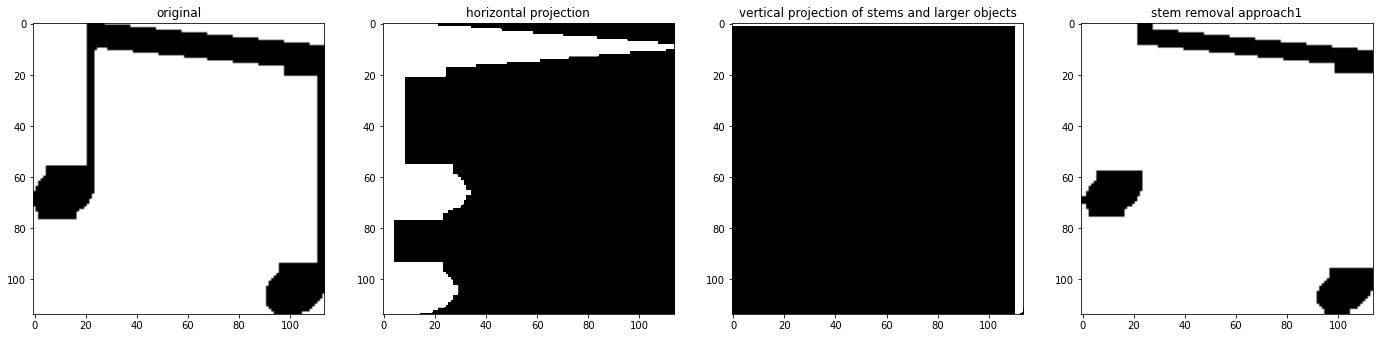

stems (positions, widths) found:  [(29, 3), (73, 3), (117, 3), (161, 2)]


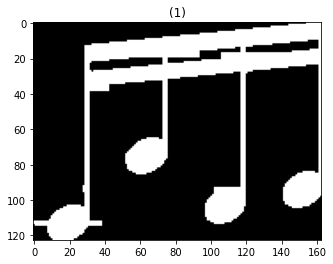

rectL_sum 7650
rectR_sum 116025
The number of labels : 6
block_Ymin : 192
num_spaces : 4.0
block lines : [211 230 249 268 287]
note_centroid : 305.4372990353698
c1
The beam is above the notes
centy 113.43729903536978
centx 20.14790996784566
object [[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
note_pos bottom
staffLineSpacing 19
mask [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
num_startpositions : 2
block_Ymin : 192
num_spaces : 2.0
block lines : [211 230 249 268 287]
note_centroid : 267.31772575250835
g1
The beam is above the notes
centy 75.31772575250837
centx 64.40802675585284
object [[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 .

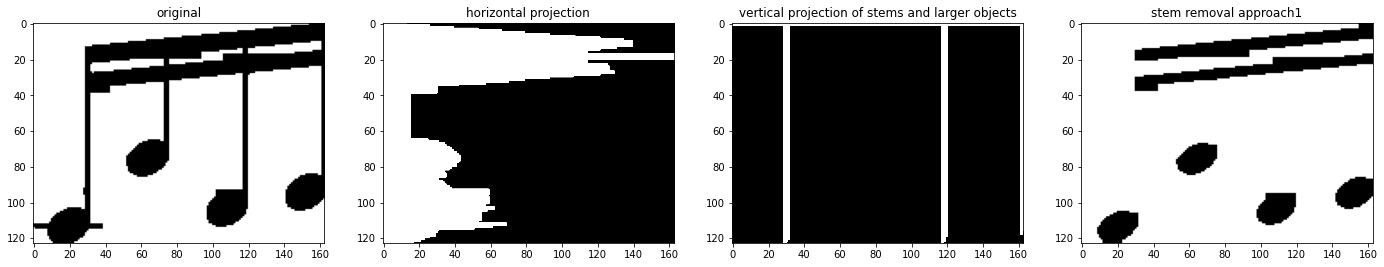

stems (positions, widths) found:  [(2, 2), (45, 3), (89, 3), (133, 4)]


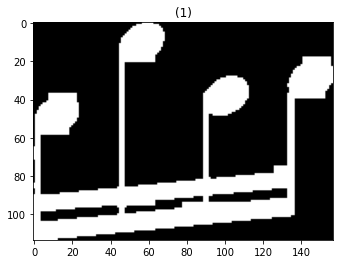

rectL_sum 107865
rectR_sum 43095
The number of labels : 6
block_Ymin : 191
num_spaces : 1.0
block lines : [211 230 249 268 287]
note_centroid : 239.34029850746268
c2
The notes are above the beam
centy 48.340298507462684
centx 12.665671641791045
object [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]
note_pos top
staffLineSpacing 19
mask [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 0 0 0]
num_startpositions : 2
block_Ymin : 191
num_spaces : 0.0
block lines : [211 230 249 268 287]
note_centroid : 201.85276073619633
g2
The notes are above the beam
centy 10.85276073619632
centx 56.95705521472393
object [[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]]
note_pos top
s

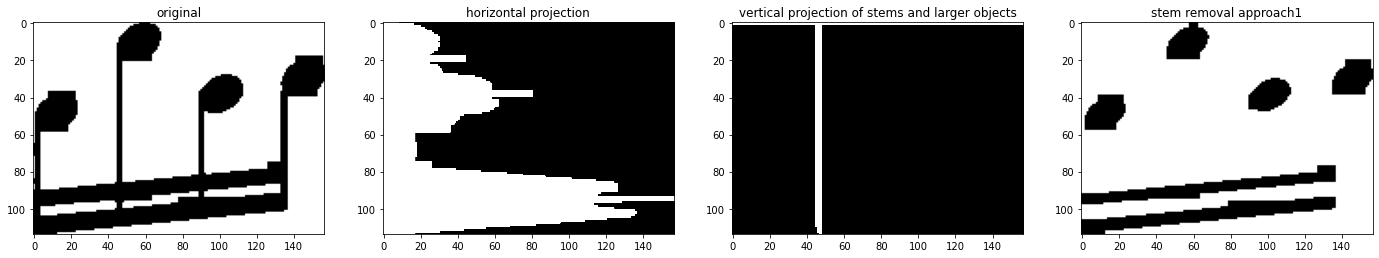

stems (positions, widths) found:  [(21, 3), (65, 3), (109, 3), (154, 2)]


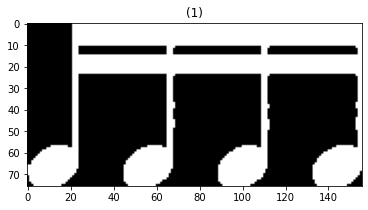

rectL_sum 29580
rectR_sum 104805
The number of labels : 6
block_Ymin : 385
num_spaces : 3.0
block lines : [377 396 415 434 453]
note_centroid : 452.0896551724138
e1
The beam is above the notes
centy 67.0896551724138
centx 12.375862068965517
object [[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
note_pos bottom
staffLineSpacing 19
mask [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
num_startpositions : 2
block_Ymin : 385
num_spaces : 3.0
block lines : [377 396 415 434 453]
note_centroid : 452.1219512195122
e1
The beam is above the notes
centy 67.1219512195122
centx 56.599303135888505
object [[  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
note_pos bottom

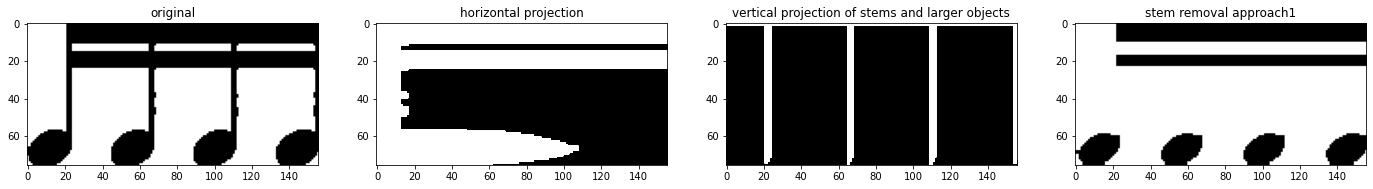

In [12]:
num_block = 0
cnt_obj = -1
for object in objects:
    cnt_obj = cnt_obj + 1
    block_num = block_info[cnt_obj][0]
    if num_block == block_num:
        num_block = num_block + 1
        continue
    # show_images([object])    
    # staffLineSpacing = 20
    testNoStem, stems = stemRemoval(object, staffLineSpacing)

    # BEAM CLASSIFICATION
    num_stems = len(stems)
    if num_stems > 1:
        print('stems (positions, widths) found: ', stems)
        orig = np.copy(object)
        object = 255 - object
        height, width = object.shape
        # check if it the beam is above or below the note heads
        show_images([object])
        rectL_sum = np.sum(object[:, :staffLineSpacing//2])
        rectR_sum = np.sum(object[:, width-(staffLineSpacing//2): width])
        print('rectL_sum', rectL_sum)
        print('rectR_sum', rectR_sum)
        # erode the object to get rid of the ledges
        se = np.ones((2 * staffLineThickness, staffLineThickness))
        testNoStem = binary_erosion((255 - testNoStem)/255, se)
        testNoStem = (testNoStem*255).astype('uint8')
        testNoStem = 255-testNoStem
        labeled_img, num_labels = label(255 - testNoStem, background=0, return_num=True, connectivity=2)
        print("The number of labels : " + str(num_labels))
        regions = regionprops(labeled_img)
        
        
        # horizontal projection for the objects with no stem
        No_Stem_horiz_proj = (np.sum((255-testNoStem)/255, axis=1)).astype('uint32')
        # visualize the bounding boxes
        bboxes = []
        bboxes_centroids = []
        for region in regions:
            rect_endpoints = region['bbox']
            # get bounding box coordinates
            min_row = rect_endpoints[0]
            min_col = rect_endpoints[1]
            max_row = rect_endpoints[2]
            max_col = rect_endpoints[3]
            bbox_width = max_col - min_col
            # print('w : ' + str(bbox_width))
            bbox_height = max_row - min_row
            # print('h : ' + str(bbox_height))
            # filter the noteheads from the beams
            # if rectL_sum > rectR_sum:
            #     beam_max_row = np.nonzero(No_Stem_horiz_proj)[0][-1]
            #     if max_row < beam_max_row:
            #         bboxes.append(rect_endpoints)
            #         bboxes_centroids.append(region['centroid'])
            # else:
            #     beam_min_row = np.nonzero(No_Stem_horiz_proj)[0][0]
            #     if min_row > beam_min_row:
            #         bboxes.append(rect_endpoints)
            #         bboxes_centroids.append(region['centroid'])
            if (bbox_height < 1.5 * staffLineSpacing) and (bbox_width < 1.5 * staffLineSpacing):
                bboxes.append(rect_endpoints)
                bboxes_centroids.append(region['centroid'])
        # for rect_endpoints in bboxes:
        #     rect_start = (rect_endpoints[0], rect_endpoints[1])
        #     rect_end = (rect_endpoints[2], rect_endpoints[3])
        #     rr, cc = rectangle_perimeter(rect_start, rect_end, shape=object.shape,clip=True)
        #     testNoStem[rr, cc] = 150
            
        #classify
        #TODO: remember to check if the equal condition can cause problems or if it is possible to happen at all in the left and right rectangles
        bboxes_centroids.sort(key=lambda x:x[1])
        bboxes.sort(key=lambda x:x[1])
        pitch_list = []
        duration_list = []
        for centroid in bboxes_centroids:
            cent_y = centroid[0]
            cent_x = centroid[1]
            # top_staff_y = staffLines[top_block_staffLine[cnt_obj]]
            # print('pos : ' + str((cent_y - top_staff_y) // staffLineSpacing))
            note_pitch = classify_note(cent_y, block_info[cnt_obj], staffLines, staffLineSpacing)
            pitch_list.append(note_pitch)
            if rectR_sum < rectL_sum:
                print("The notes are above the beam")
                note_dur = calc_duration(cent_y, cent_x, 255 - testNoStem, 'top', staffLineSpacing)
            else:
                print("The beam is above the notes")
                note_dur = calc_duration(cent_y, cent_x, 255 - testNoStem, 'bottom', staffLineSpacing)
            duration_list.append(note_dur)
        
        print('pitch_list : ' + str(pitch_list))
        print('duration_list : ' + str(duration_list))

        horiz_proj = (np.sum(object/255, axis=1)).astype('uint32')
        vert_proj = (np.sum(object/255, axis=0)).astype('uint32')
        # visualize the horizontal projection
        m = np.max(horiz_proj, initial=0)
        if m == 0:
            m = 1
        result = np.zeros((height,width))
        # Draw a line for each row
        for row in range(height):
            cv2.line(result, (0,row), (int(horiz_proj[row]*width/m),row), 255, 1)

        # visualize the vertical projection
        m = np.max(vert_proj, initial=0)
        if m == 0:
            m = 1
        result2 = np.zeros((height, width))
        
        # thresholding to remove non stems from the image in the vertical projection for visualisation
        max_vertical = 0.8 * m
        vert_proj = np.where(vert_proj <= max_vertical, 0, vert_proj)
        mask = np.where(vert_proj!=0, 1, 0)
        # Draw a line for each row
        for col in range(width):
            cv2.line(result2, (col,0), (col,int(vert_proj[col]*height/m)), 255, 1)

        show_images([orig, result, result2, testNoStem], ['original', 'horizontal projection', 'vertical projection of stems and larger objects', 'stem removal approach1'])

In [119]:
import matplotlib.pyplot as plt
from matplotlib import cm

def tstaffLineRemoval(thresholdedImg, thicknessThresholdFraction):
    img = np.copy(thresholdedImg)  # for convinience :)
    height, width = img.shape
    # Invert the input binary image
    imgBinary = 255 - img

    # apply hough lines to detect stafflines
    hspace, angles, dists = hough_line(imgBinary)
    hspac, angle, distan = hough_line_peaks(hspace, angles, dists)
    filtered_dists = []
    temp_cnt = -1
    print('angles : ' + str(angle))
    for a in angle:
        temp_cnt = temp_cnt + 1
        if a >= 1.56 and a <= 1.58:
            filtered_dists.append(dists[temp_cnt])
    # ---------------------------------------------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(thresholdedImg, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + hspace),
                extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), dists[-1], dists[0]],
                cmap=cm.gray, aspect=1/1.5)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    ax[2].imshow(thresholdedImg, cmap=cm.gray)
    origin = np.array((0, thresholdedImg.shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(hspace, angles, dists)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        ax[2].plot(origin, (y0, y1), '-r')
    ax[2].set_xlim(origin)
    ax[2].set_ylim((thresholdedImg.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    plt.tight_layout()
    plt.show()
    # ---------------------------------------------------------------------------
    staffLines = np.sort(np.round(distan).astype('int32'))
    # remove negative staffLines 
    staffLines = staffLines[staffLines >= 0]
    print('staffLines from staffLineRemoval : ' + str(staffLines))
    # find most common black pixel run length (white pixel run length in binary image due to inversion)
    # This should correspond to staff line thickness
    staffLineThickness = verticalRunLengthMode(imgBinary, 255, width, height)
    # TODO: check whether the addition is needed
    staffLineSpacing = verticalRunLengthMode(imgBinary, 0, width, height)

    threshold = staffLineSpacing / 2  # TODO: check whether needed
    for staffLineRow in staffLines:
        for x in range(width-1, 0, -1):
            if img[staffLineRow, x] != 0:
                for j in range(1, round(threshold/2)):
                    if img[staffLineRow + j, x] == 0:
                        staffLineRow = staffLineRow + j
                        break
                    if img[staffLineRow - j, x] == 0:
                        staffLineRow = staffLineRow - j
                        break
            verticalThresholdResult = testVerticalThreshold(
                img, x, staffLineRow, staffLineThickness*thicknessThresholdFraction)
            if(verticalThresholdResult[0]):
                rr, cc = line(
                    verticalThresholdResult[1], x, verticalThresholdResult[2], x)
                img[rr, cc] = 150
        # TODO: fix with morphology the broken objects
    return (img, staffLines)


angles : [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633]


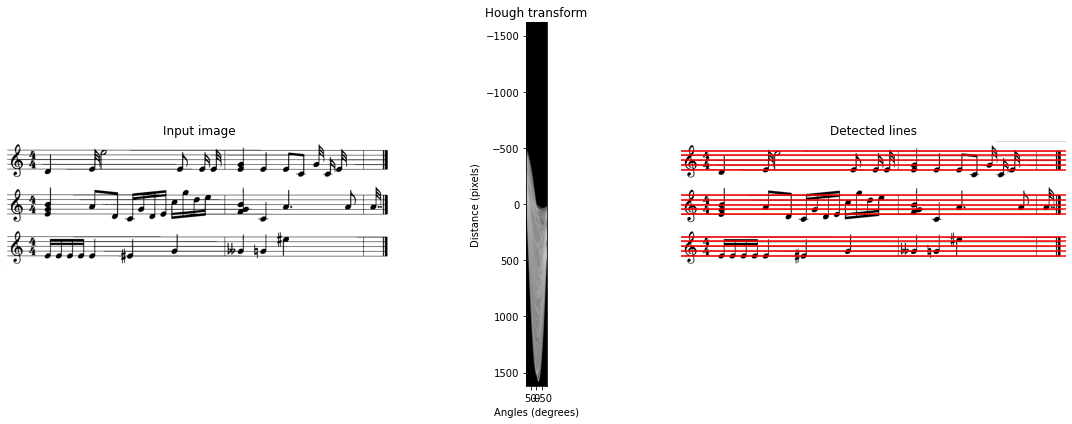

staffLines from staffLineRemoval : [ 41  60  78  97 116 218 237 256 275 294 384 403 422 441 460]


NameError: name 'verticalRunLengthMode' is not defined

In [120]:


img = rgb2gray(io.imread('dataset/scanned/13.PNG'))
# noisy_img = random_noise(img, mode='s&p', amount=0.1)
# noisy_img = (noisy_img * 255).astype(np.uint8)
# Median filtering using the hybrid Median filter
img_gray = img
if img_gray.dtype != np.uint8:
    img_gray = (img_gray * 255).astype(np.uint8)

img_median_filtered = (hybridMedian(img_gray)).astype(np.uint8)

# gaussian filtering
img_gaussian_filtered = (gaussian(img_median_filtered, sigma=0.2)* 255).astype(np.uint8)

image_rotated = (skew_angle_hough_transform(img_gaussian_filtered)* 255).astype(np.uint8)
# image binarization
binary = adaptiveThresh(image_rotated, t=15, div=8)
# image rotation

# show_images([img, img_gray, img_median_filtered, img_gaussian_filtered, binary, image_rotated])

# staff line removal
image_no_staff, stuff = tstaffLineRemoval(binary, 1)
show_images([image_no_staff])
print(stuff)